## Analysis on 2011_09_30_0033

This notebook analysis the comparison between Extended Kalman Filter (EKF) and Unscented Kalman Filter (UKF) on kitti dataset found on (link)

### Import libraries

In [1]:
import numpy as np
import pykitti
import sys
import matplotlib.pyplot as plt

from read_kitti_data import LoadKittiData
from ExtendedKalmanFilter import ExtendedKalmanFilter
from UnscentedKalmanFilter import UnscentedKalmanFilter
from filter_estimation import Filter_Estimation, apply_estimation_filter
from helper_functions import lla_to_enu, normalize_angles

%matplotlib inline
np.random.seed(10)

### Read file

In [2]:
kitti_root_dir = '../data/kitti'
kitti_date = '2011_09_30'
kitti_drive = '0033'
kitti_data = LoadKittiData(kitti_root_dir, kitti_date, kitti_drive)

## Case 1: low noise

### Defining the noise 

In [3]:
obs_noise_std=[5, 5, np.pi]
input_noise_std=[0.3, 0.02]

In [4]:
kitti_data.add_gaussian_noise_observation(obs_noise_std)
kitti_data.add_gaussian_noise_control_input(input_noise_std)

### Plot of control input data

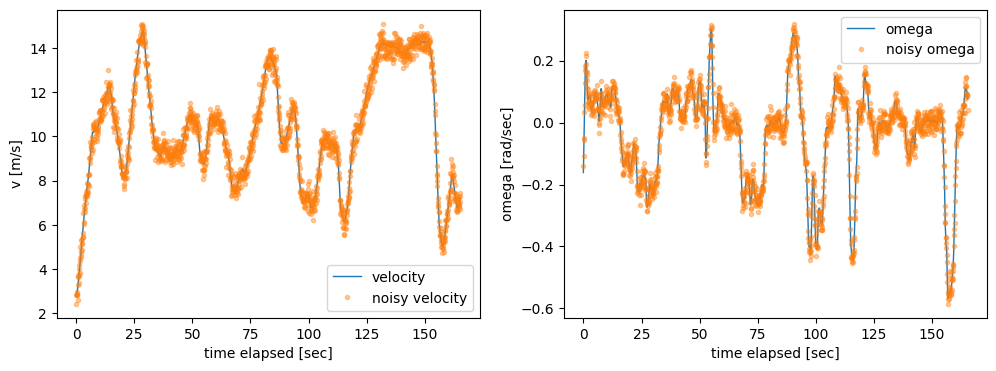

In [5]:
kitti_data.plot_control_input_data()

### Plot of observation data

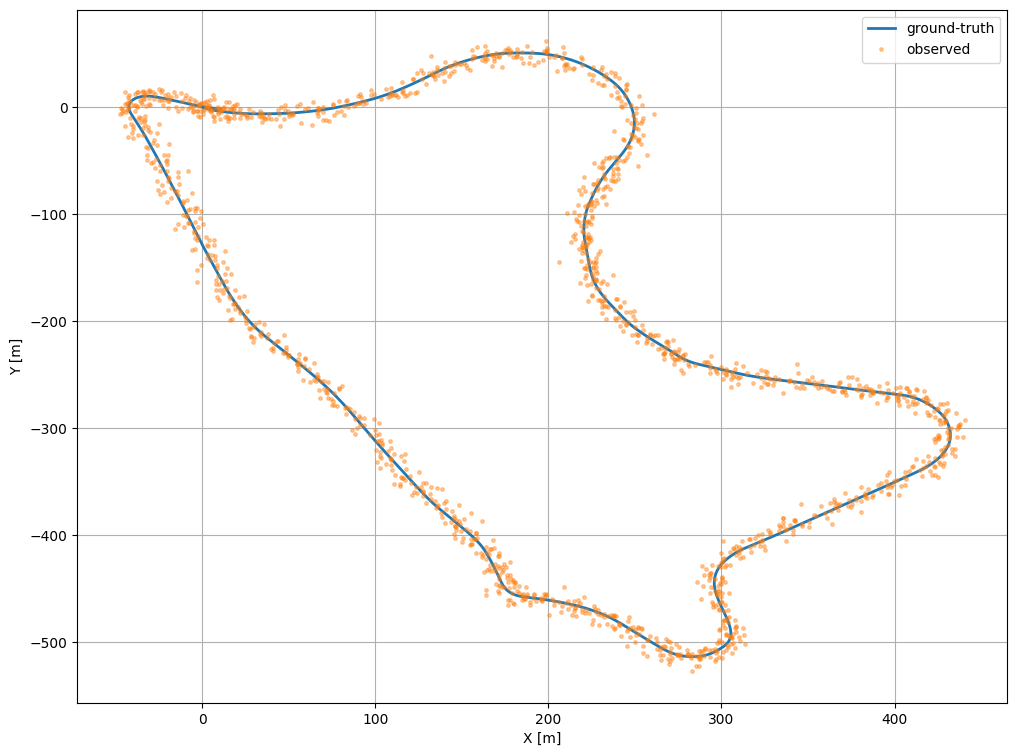

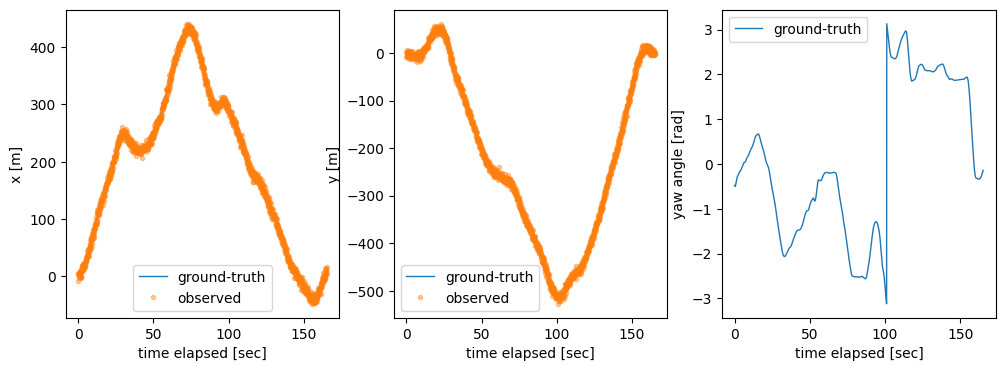

In [6]:
kitti_data.plot_observation_data()

### Initialising state and covariance

In [7]:
# initial state x_0
initial_theta_std = np.pi
initial_theta = normalize_angles(np.random.normal(0, initial_theta_std))

x_0 = np.array([
    kitti_data.observation_states[0, 0],
    kitti_data.observation_states[1, 0],
    initial_theta
])
x_0

array([ 6.65793252, -9.16641204,  0.15475872])

In [8]:
# covariance for initial state estimation error (Sigma_0)
P_0 = np.array([
    [obs_noise_std[0] ** 2., 0., 0.],
    [0., obs_noise_std[1] ** 2., 0.],
    [0., 0., obs_noise_std[2] ** 2.]
])
P_0

array([[25.       ,  0.       ,  0.       ],
       [ 0.       , 25.       ,  0.       ],
       [ 0.       ,  0.       ,  9.8696044]])

In [9]:
# measurement error covariance Q
Q = np.array([
    [obs_noise_std[0] ** 2., 0.],
    [0., obs_noise_std[1] ** 2.]
])
Q

array([[25.,  0.],
       [ 0., 25.]])

In [10]:
# 
R = np.array([
    [input_noise_std[0] ** 2., 0., 0.],
    [0., input_noise_std[0] ** 2., 0.],
    [0., 0., input_noise_std[1] ** 2.]
])
R

array([[0.09  , 0.    , 0.    ],
       [0.    , 0.09  , 0.    ],
       [0.    , 0.    , 0.0004]])

### Extended Kalman Filter

In [11]:
ekf_estimated_state = apply_estimation_filter(kitti_data, 'EKF', x_0, P_0, R, Q)

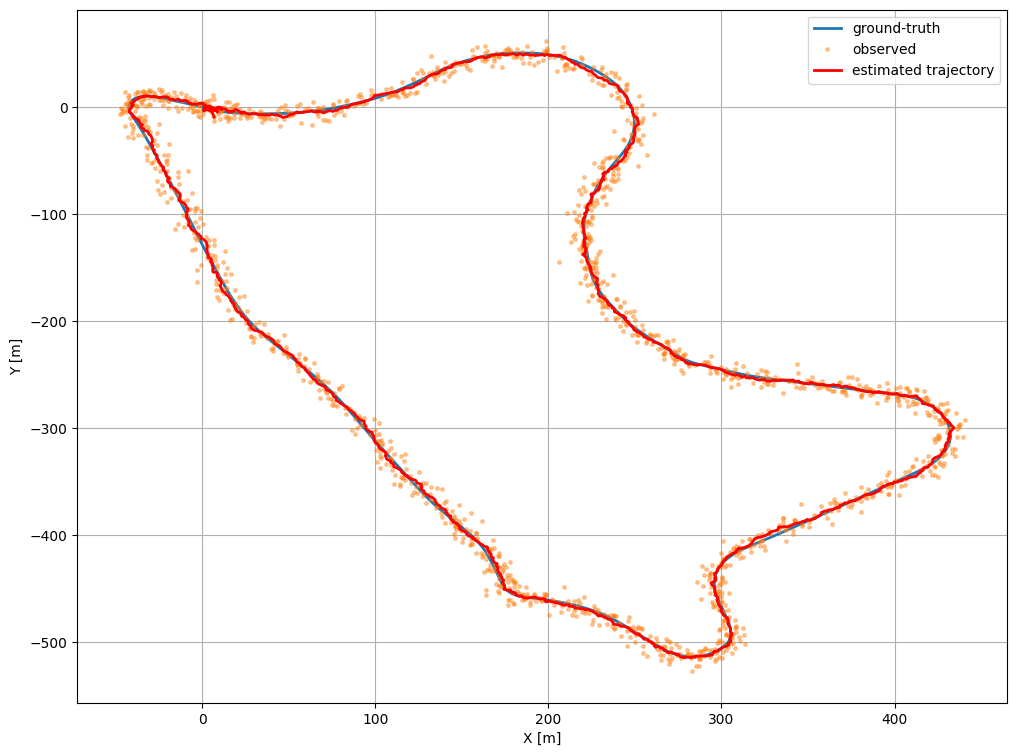

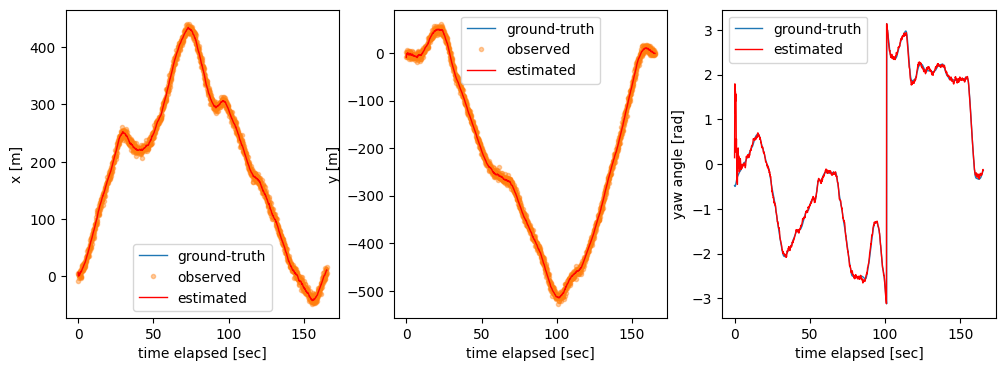

In [12]:
kitti_data.plot_estimated_data(ekf_estimated_state)

In [13]:
kitti_data.evaluate_filter(ekf_estimated_state)

{'RMSE': array([1.42784358, 1.34288434, 0.16460705]),
 'MAE': array([1.15096239, 1.06795002, 0.05061752]),
 'MSE': array([2.0387373 , 1.80333835, 0.02709548]),
 'NRMSE': array([0.00150963, 0.00141981, 0.00017404]),
 'Mean_Error': array([-0.10072616,  0.13445809, -0.01673366]),
 'Std_Error': array([1.42428633, 1.33613599, 0.16375429]),
 'Mean_Angular_Error': -0.016733659194644143}

### Unscented Kalman Filter

In [14]:
ukf_estimated_state = apply_estimation_filter(kitti_data, 'UKF', x_0, P_0, R, Q)

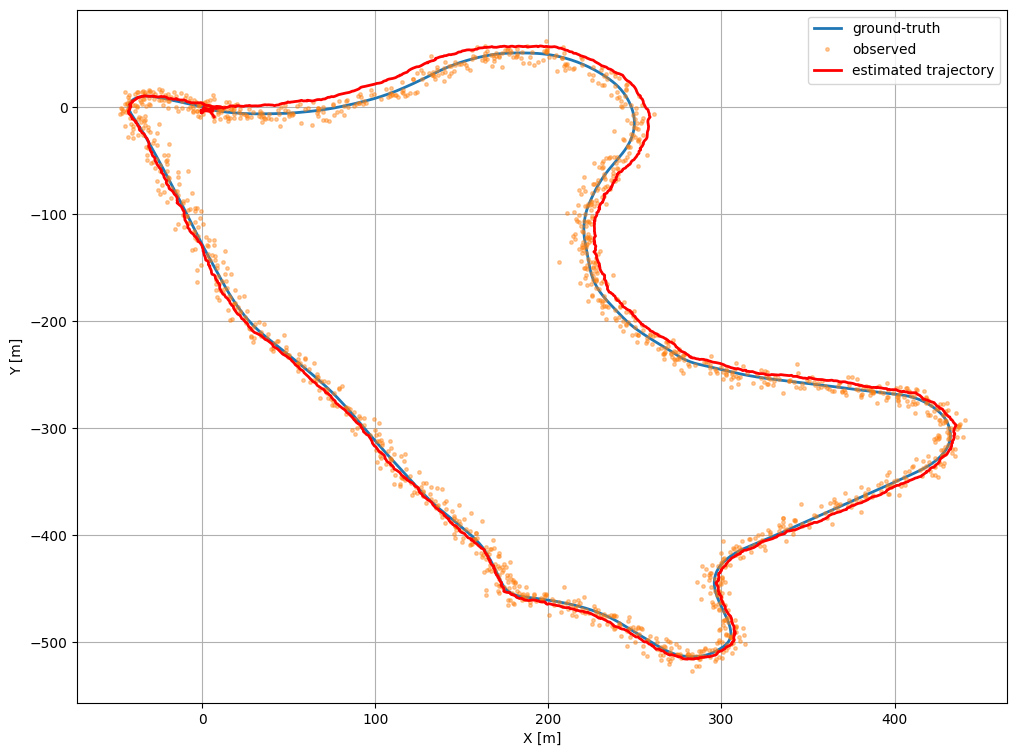

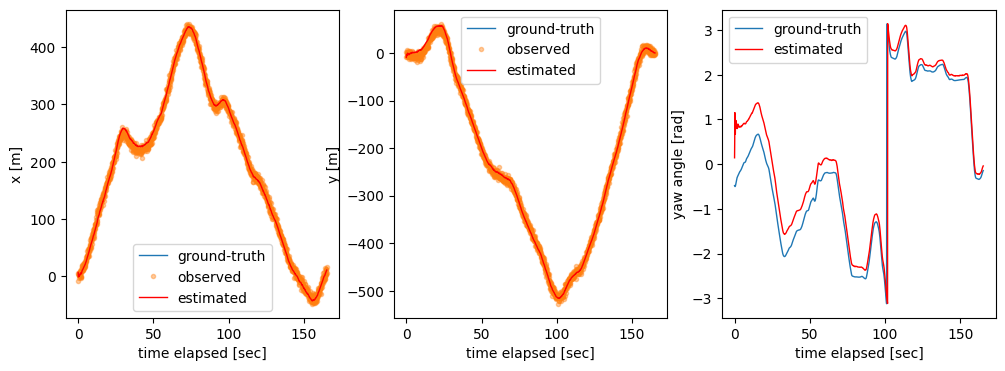

In [15]:
kitti_data.plot_estimated_data(ukf_estimated_state)

In [16]:
kitti_data.evaluate_filter(ukf_estimated_state)

{'RMSE': array([3.53599824, 3.79718138, 0.40684624]),
 'MAE': array([2.57359627, 2.92352798, 0.32187786]),
 'MSE': array([12.50328355, 14.41858644,  0.16552386]),
 'NRMSE': array([0.00373855, 0.00401469, 0.00043015]),
 'Mean_Error': array([-0.41573917, -1.30398493, -0.32187786]),
 'Std_Error': array([3.51147327, 3.56625991, 0.24883428]),
 'Mean_Angular_Error': -0.3218778644058794}

### Compare yaw angle

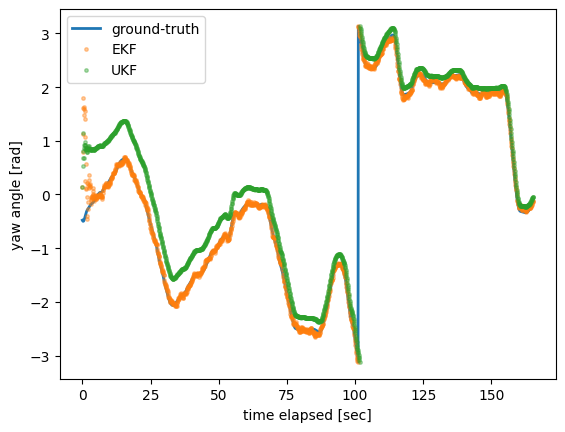

In [17]:
timestamps = kitti_data.timestamps
original_yaw_angle = kitti_data.ground_truth_states[2, :]
ekf_estimated = ekf_estimated_state[2, :]
ukf_estimated = ukf_estimated_state[2, :]

fig = plt.figure()
plt.plot(timestamps, original_yaw_angle, lw=2, label="ground-truth")
plt.plot(timestamps, ekf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='EKF')
plt.plot(timestamps, ukf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='UKF')
plt.xlabel('time elapsed [sec]')
plt.ylabel('yaw angle [rad]')
plt.legend()
plt.savefig('2011_09_30_0033_01.png', bbox_inches='tight')
#plt.show()

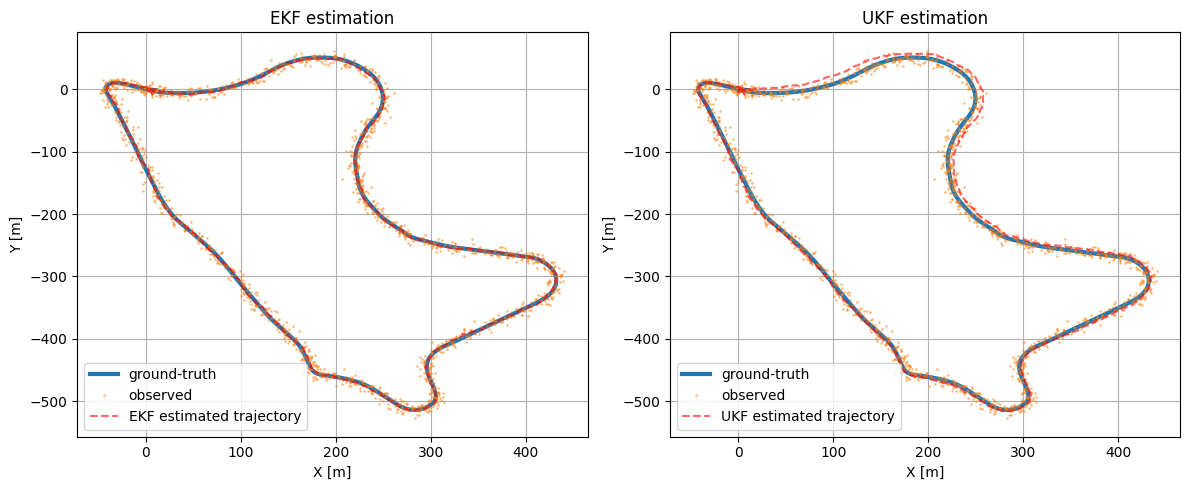

In [18]:
fig, axarr = plt.subplots(1, 2, figsize=(12,5))
ax = axarr[0]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='EKF estimated trajectory', color='r')
#ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='UKF estimated trajectory', color='g')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('EKF estimation')
ax.grid()
ax.legend()

ax = axarr[1]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
#ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='EKF estimated trajectory', color='r')
ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='UKF estimated trajectory', color='r')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('UKF estimation')
ax.grid()
ax.legend()

plt.tight_layout()
#plt.show()
plt.savefig('2011_09_30_0033.png', bbox_inches='tight')

## Case 2: high noise

### Defining noises

In [19]:
obs_noise_std=[15, 15, np.pi]
input_noise_std=[0.9, 0.06]

In [20]:
kitti_data.add_gaussian_noise_observation(obs_noise_std)
kitti_data.add_gaussian_noise_control_input(input_noise_std)

### Plot control input data

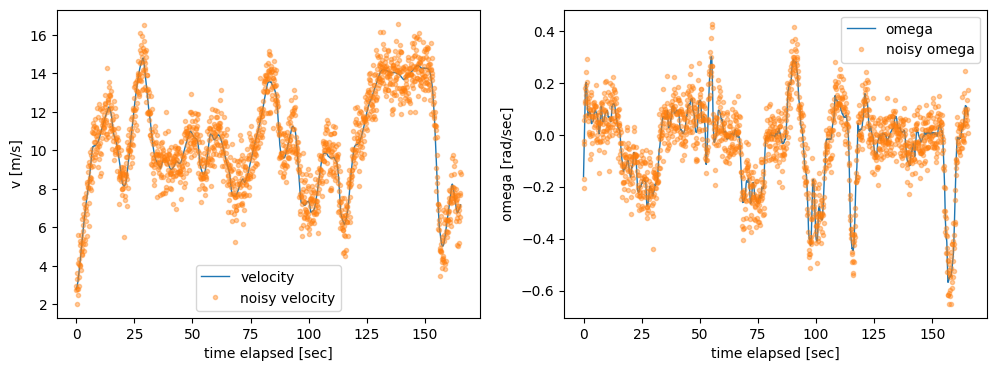

In [21]:
kitti_data.plot_control_input_data()

### Plot observation data

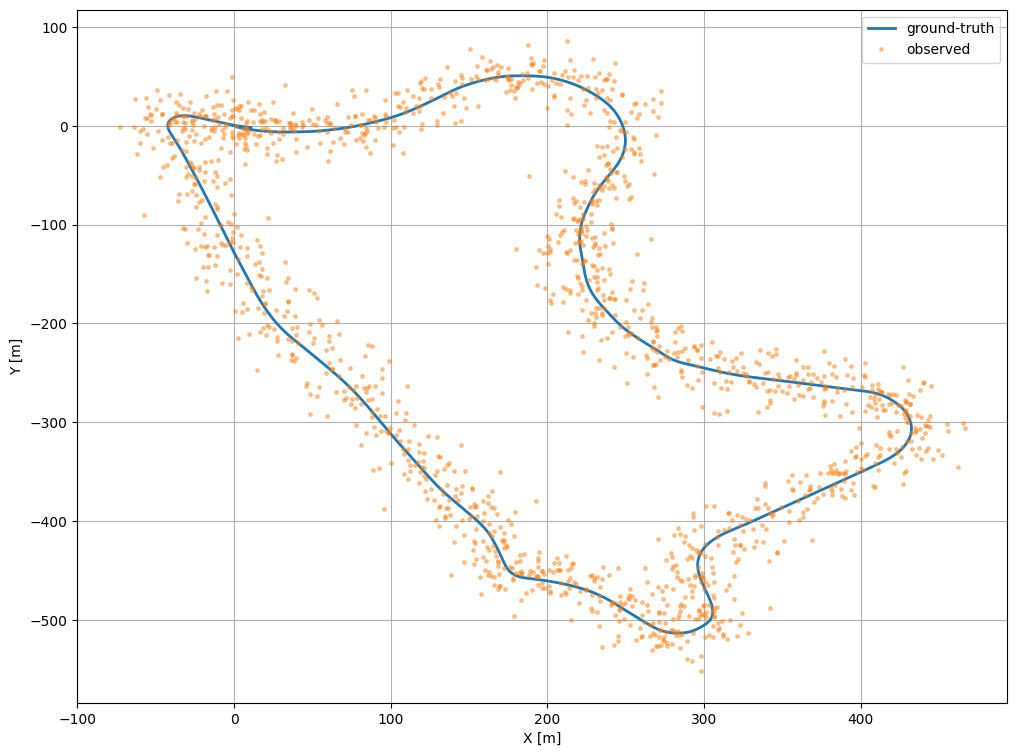

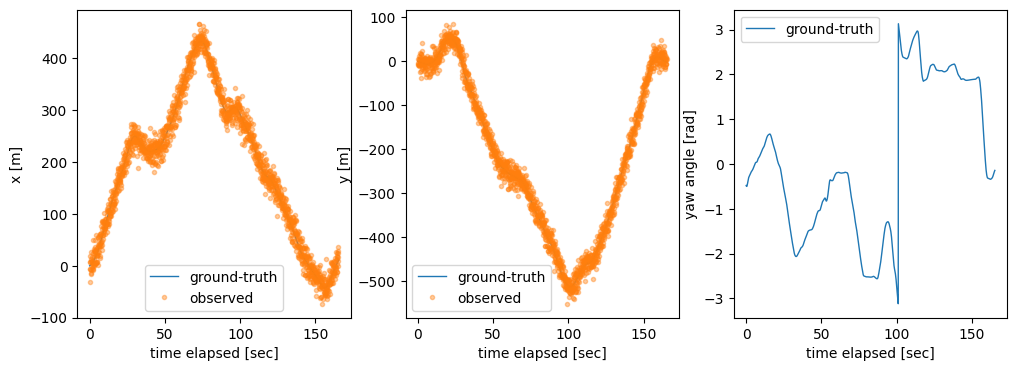

In [22]:
kitti_data.plot_observation_data()

### Initialise state and covariance

In [23]:
# initial state x_0
initial_theta_std = np.pi
initial_theta = normalize_angles(np.random.normal(0, initial_theta_std))

x_0 = np.array([
    kitti_data.observation_states[0, 0],
    kitti_data.observation_states[1, 0],
    initial_theta
])
x_0

array([18.02726782, -3.49313167, -2.26934686])

In [24]:
# covariance for initial state estimation error (Sigma_0)
P_0 = np.array([
    [obs_noise_std[0] ** 2., 0., 0.],
    [0., obs_noise_std[1] ** 2., 0.],
    [0., 0., obs_noise_std[2] ** 2.]
])
P_0

array([[225.       ,   0.       ,   0.       ],
       [  0.       , 225.       ,   0.       ],
       [  0.       ,   0.       ,   9.8696044]])

In [25]:
# measurement error covariance Q
Q = np.array([
    [obs_noise_std[0] ** 2., 0.],
    [0., obs_noise_std[1] ** 2.]
])
Q

array([[225.,   0.],
       [  0., 225.]])

In [26]:
#
R = np.array([
    [input_noise_std[0] ** 2., 0., 0.],
    [0., input_noise_std[0] ** 2., 0.],
    [0., 0., input_noise_std[1] ** 2.]
])
R

array([[0.81  , 0.    , 0.    ],
       [0.    , 0.81  , 0.    ],
       [0.    , 0.    , 0.0036]])

### Extended Kalman Filter

In [27]:
ekf_estimated_state = apply_estimation_filter(kitti_data, 'EKF', x_0, P_0, R, Q)

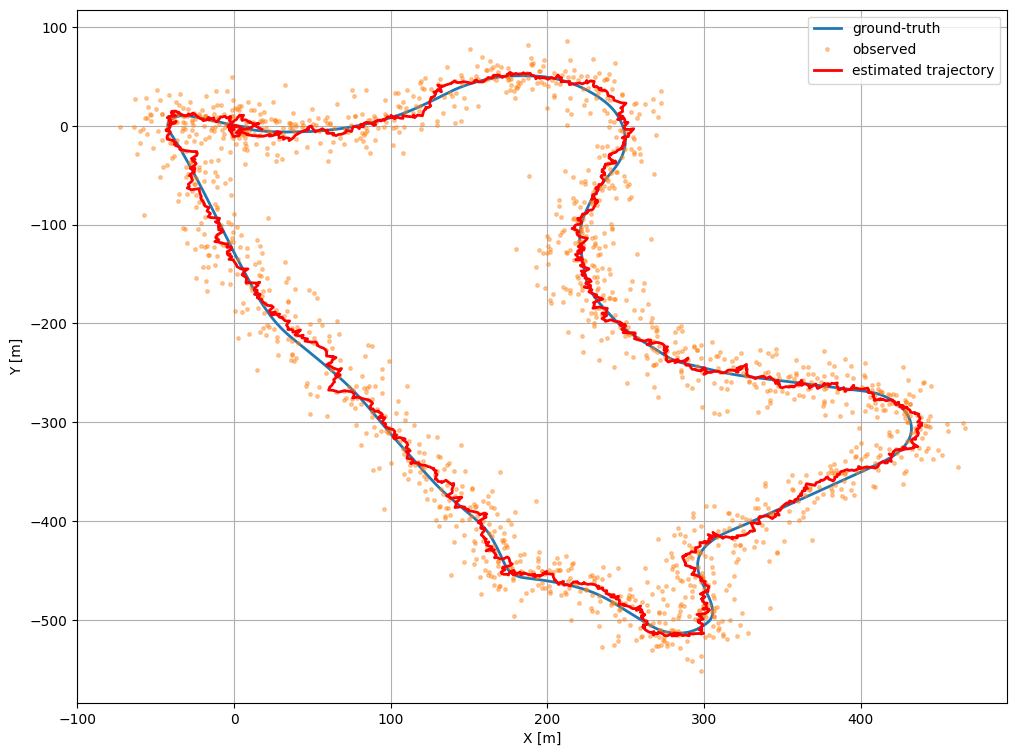

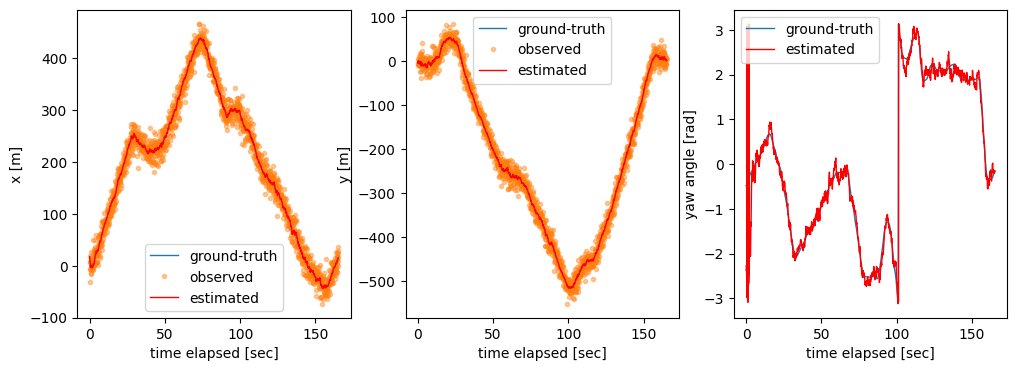

In [28]:
kitti_data.plot_estimated_data(ekf_estimated_state)

In [29]:
kitti_data.evaluate_filter(ekf_estimated_state)

{'RMSE': array([3.85502399, 3.37258054, 0.32516844]),
 'MAE': array([3.14553577, 2.74974293, 0.13955373]),
 'MSE': array([14.86120998, 11.37429953,  0.10573452]),
 'NRMSE': array([0.00407585, 0.00356577, 0.00034379]),
 'Mean_Error': array([-0.37564625, -1.07777937,  0.04263191]),
 'Std_Error': array([3.83667823, 3.19573015, 0.32236165]),
 'Mean_Angular_Error': 0.042631912039798076}

In [30]:
ukf_estimated_state = apply_estimation_filter(kitti_data, 'UKF', x_0, P_0, R, Q)

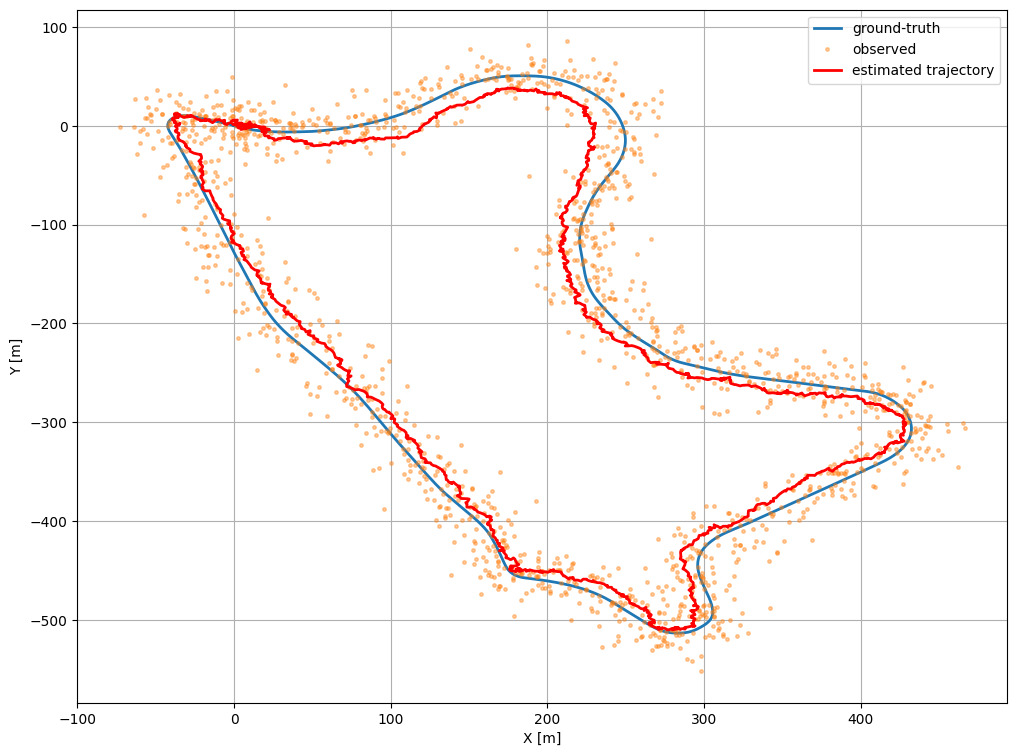

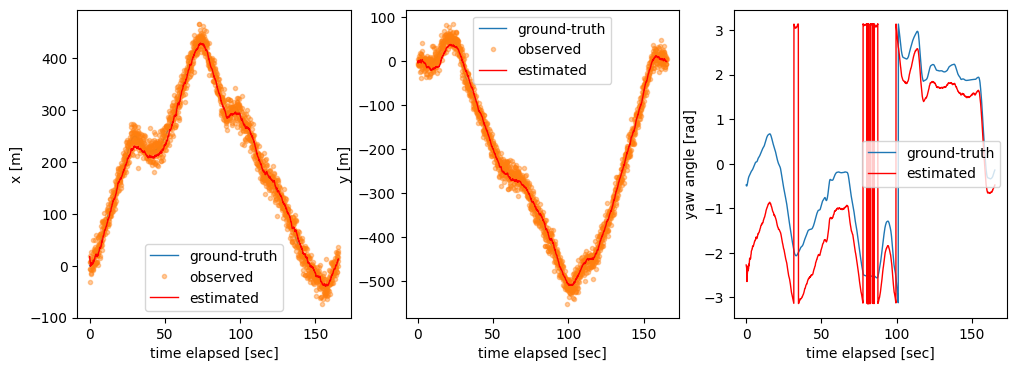

In [31]:
kitti_data.plot_estimated_data(ukf_estimated_state)

In [32]:
kitti_data.evaluate_filter(ukf_estimated_state)

{'RMSE': array([9.07062361, 8.99545309, 0.90892162]),
 'MAE': array([7.74215674, 6.7260697 , 0.79020743]),
 'MSE': array([82.27621272, 80.91817632,  0.82613851]),
 'NRMSE': array([0.00959021, 0.00951073, 0.00096099]),
 'Mean_Error': array([ 2.8939796 , -0.70822345,  0.79020743]),
 'Std_Error': array([8.5965746 , 8.96753009, 0.44912217]),
 'Mean_Angular_Error': 0.7902074341987243}

### Compare yaw angle

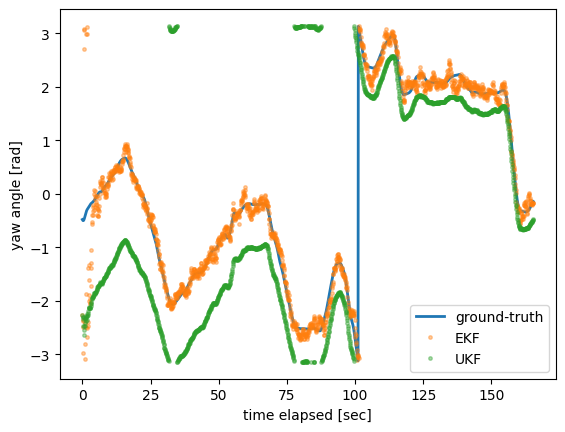

In [33]:
timestamps = kitti_data.timestamps
original_yaw_angle = kitti_data.ground_truth_states[2, :]
ekf_estimated = ekf_estimated_state[2, :]
ukf_estimated = ukf_estimated_state[2, :]

fig = plt.figure()
plt.plot(timestamps, original_yaw_angle, lw=2, label="ground-truth")
plt.plot(timestamps, ekf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='EKF')
plt.plot(timestamps, ukf_estimated, marker='.', lw=0, markersize=5, alpha=0.4, label='UKF')
plt.xlabel('time elapsed [sec]')
plt.ylabel('yaw angle [rad]')
plt.legend()
plt.savefig('2011_09_30_0033_02.png', bbox_inches='tight')
#plt.show()

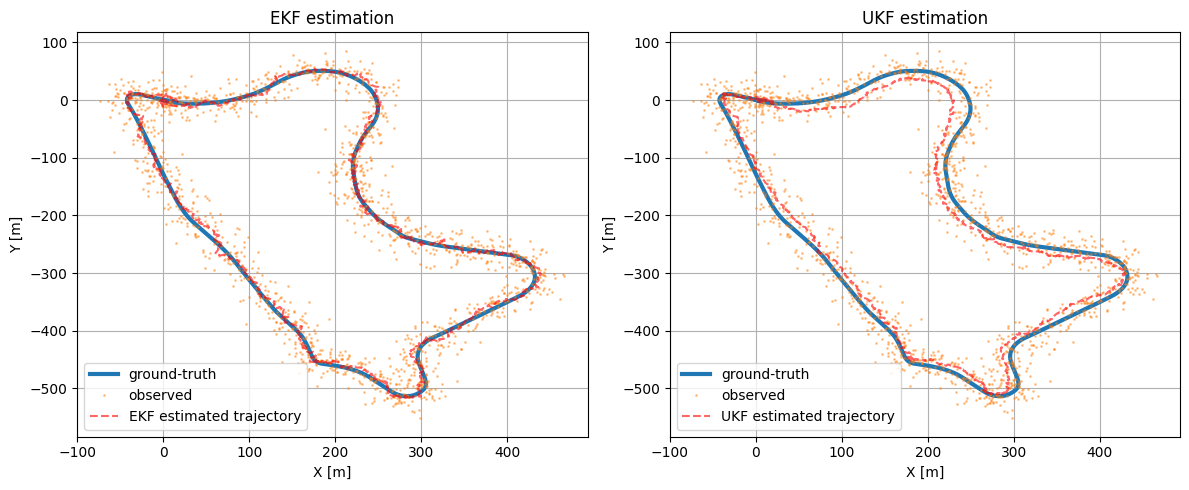

In [34]:
fig, axarr = plt.subplots(1, 2, figsize=(12,5))
ax = axarr[0]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='EKF estimated trajectory', color='r')
#ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='UKF estimated trajectory', color='g')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('EKF estimation')
ax.grid()
ax.legend()

ax = axarr[1]
ax.plot(kitti_data.ground_truth_states[0, :], kitti_data.ground_truth_states[1, :], lw=3, label='ground-truth')
ax.plot(kitti_data.observation_states[0, :], kitti_data.observation_states[1, :], lw=0, marker='.', markersize=2, alpha=0.4, label='observed')
#ax.plot(ekf_estimated_state[0, :], ekf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.99, label='EKF estimated trajectory', color='r')
ax.plot(ukf_estimated_state[0, :], ukf_estimated_state[1, :], linestyle='dashed', lw=1.5, alpha=0.6, label='UKF estimated trajectory', color='r')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
#ax.set_ylim([-70, 55])
#ax.set_xlim([-350, 180])
ax.title.set_text('UKF estimation')
ax.grid()
ax.legend()

plt.tight_layout()
#plt.show()
plt.savefig('2011_09_30_0033_04.png', bbox_inches='tight')